## Load library

In [9]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt # for plotting
from tabulate import tabulate
import seaborn as sns

In [10]:
%load_ext watermark
%watermark --iversions

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
keras     : 3.13.1
matplotlib: 3.10.8
numpy     : 2.3.5
pandas    : 2.3.3
seaborn   : 0.13.2
sklearn   : 1.8.0
tabulate  : 0.9.0
tensorflow: 2.20.0



## Definition of functions

In [5]:
def conf_matrixBig(model, val, val_lb, name='confusion_matrix.pdf'):
    # Generate model predictions on validation data
    y_pred_probs = model.predict(val)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(val_lb, axis=1)

    # Compute the basic confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Row-wise metrics (true classes)
    row_sums = cm.sum(axis=1, keepdims=True)  # Total samples per true class
    cm_row_perc = cm / row_sums               # Normalized per-row matrix
    row_accuracy = np.diag(cm) / row_sums.flatten()  # Accuracy per true class
    row_error = 1 - row_accuracy              # Error per true class

    # Column-wise metrics (predicted classes)
    col_sums = cm.sum(axis=0, keepdims=True)  # Total samples per predicted class
    col_accuracy = np.diag(cm) / col_sums.flatten()  # Accuracy per predicted class
    col_error = 1 - col_accuracy              # Error per predicted class

    # Extend confusion matrix with accuracy/error rows and columns
    cm_extended = np.zeros((cm.shape + 2, cm.shape + 2))
    cm_extended[:-2, :-2] = cm
    cm_extended[:-2, -2] = row_accuracy * 100     # Row accuracy [%]
    cm_extended[:-2, -1] = row_error * 100        # Row error [%]
    cm_extended[-2, :-2] = col_accuracy * 100     # Column accuracy [%]
    cm_extended[-1, :-2] = col_error * 100        # Column error [%]
    cm_extended[-2, -2] = np.sum(np.diag(cm)) / np.sum(cm) * 100  # Overall accuracy [%]
    cm_extended[-1, -1] = 100 - cm_extended[-2, -2]               # Overall error [%]

    # Define labels and appearance settings
    class_names = ['PA 6', 'PET', 'PA 6.6', 'PP', 'Cotton', 'Wool']
    xticklabels = class_names + ['Acc.[%]', 'Err.[%]']
    yticklabels = class_names + ['Acc.[%]', 'Err.[%]']
    fontsize = 25

    # Masked cells (exclude extended part from colormap scaling)
    mask = np.zeros_like(cm_extended, dtype=bool)
    mask[-2:, :] = True
    mask[:, -2:] = True

    # Plot the main confusion matrix with color scaling
    plt.figure(figsize=(16, 14))
    ax = sns.heatmap(
        cm_extended,
        annot=True,
        fmt='.1f',
        cmap='Blues',
        mask=mask,
        xticklabels=xticklabels,
        yticklabels=yticklabels,
        cbar_kws={'label': 'Count'},
        cbar=True,
        annot_kws={'size': fontsize}
    )

    # Adjust colorbar properties
    cbar = ax.collections.colorbar
    cbar.set_label('Count', fontsize=fontsize)
    cbar.ax.tick_params(labelsize=fontsize)

    # Highlight accuracy/error rows and columns in light yellow
    ax = plt.gca()
    for i in range(cm_extended.shape - 2, cm_extended.shape):  # Last two rows
        for j in range(cm_extended.shape):
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='lightyellow', edgecolor='black', lw=0.5))
            plt.text(j + 0.5, i + 0.5, f"{cm_extended[i, j]:.1f}",
                    ha='center', va='center', color='black', fontsize=fontsize)

    for i in range(cm_extended.shape):  # Last two columns
        for j in range(cm_extended.shape - 2, cm_extended.shape):
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='lightyellow', edgecolor='black', lw=0.5))
            plt.text(j + 0.5, i + 0.5, f"{cm_extended[i, j]:.1f}",
                    ha='center', va='center', color='black', fontsize=fontsize)

    # Add titles and axis labels
    ax.set_xlabel('Predicted Labels', fontsize=25)
    ax.set_ylabel('True Labels', fontsize=25)
    ax.set_title('Confusion Matrix with Accuracy and Error Rates', fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

    # Export the figure as a high-resolution PDF
    plt.savefig(name, format='pdf', dpi=300, bbox_inches='tight')


def model_summary(model):
    headers = ["Layer", "Type", "Name", "Neurons", "Activation", "Dropout", "Regularization (L1, L2)", "Input Shape", "Output Shape"]
    table_data = []

    for i, layer in enumerate(model.layers):
        layer_info = [f"Layer {i+1}"]
        layer_info.append(layer.__class__.__name__)
        layer_info.append(layer.name)
        
        neurons = layer.units if hasattr(layer, 'units') else '-'
        layer_info.append(neurons)
        
        activation = layer.activation.__name__ if hasattr(layer, 'activation') else '-'
        layer_info.append(activation)
        
        dropout = layer.rate if isinstance(layer, tf.keras.layers.Dropout) else '-'
        layer_info.append(dropout)
        
        regularization = []
        if hasattr(layer, 'kernel_regularizer') and layer.kernel_regularizer:
            l1, l2 = get_l1_l2(layer.kernel_regularizer)
            regularization.append(f"Kernel: L1={l1}, L2={l2}")
        if hasattr(layer, 'bias_regularizer') and layer.bias_regularizer:
            l1, l2 = get_l1_l2(layer.bias_regularizer)
            regularization.append(f"Bias: L1={l1}, L2={l2}")
        if hasattr(layer, 'activity_regularizer') and layer.activity_regularizer:
            l1, l2 = get_l1_l2(layer.activity_regularizer)
            regularization.append(f"Activity: L1={l1}, L2={l2}")
        layer_info.append("\n".join(regularization) if regularization else '-')
        
        table_data.append(layer_info)

    print(tabulate(table_data, headers=headers, tablefmt="grid"))
    print(f"\nTotal layers: {len(model.layers)}")

def get_l1_l2(regularizer):
    if isinstance(regularizer, tf.keras.regularizers.L1L2):
        return regularizer.l1, regularizer.l2
    elif isinstance(regularizer, tf.keras.regularizers.L1):
        return regularizer.l1, 0.0
    elif isinstance(regularizer, tf.keras.regularizers.L2):
        return 0.0, regularizer.l2
    else:
        return 0.0, 0.0

## Load data and model

In [7]:
x_train_Znorm=pd.read_csv('data/x_train_Znorm.csv')
x_val_Znorm=pd.read_csv('data/x_val_Znorm.csv')
y_train=np.load('data/y_train.npy')
y_val=np.load('data/y_val.npy')

# Join train and val for whole dataset evaluation
xx_val=pd.concat([x_train_Znorm,x_val_Znorm],axis=0,ignore_index=True)
yy_val=np.concatenate((y_train,y_val), axis=0)


best_model= load_model('data/best_model_v2_20.keras')

## Model Summary

In [4]:
model_summary(best_model)
best_model.summary(None,None,None,True,True,None)

+----------+--------------------+--------------------------+-----------+--------------+-----------+-----------------------------+
| Layer    | Type               | Name                     | Neurons   | Activation   | Dropout   | Regularization (L1, L2)     |
+==========+====================+==========================+===========+==============+===========+=============================+
| Layer 1  | Dense              | dense_14075              | 256       | relu         | -         | Kernel: L1=0.001, L2=0.01   |
|          |                    |                          |           |              |           | Bias: L1=0.0, L2=0.01       |
|          |                    |                          |           |              |           | Activity: L1=0.0, L2=1e-05  |
+----------+--------------------+--------------------------+-----------+--------------+-----------+-----------------------------+
| Layer 2  | BatchNormalization | batch_normalization_8445 | -         | -            | - 

Model: "sequential_2815"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ dense_14075 (Dense)         │ (None, 256)           │     18,688 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_8445    │ (None, 256)           │      1,024 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_8445 (Dropout)      │ (None, 256)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_14076 (Dense)         │ (None, 128)           │     32,896 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_8446    │ (None, 128)           │        512 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_8446 (Dropout)      │ (None, 128)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_14077 (Dense)         │ (None, 64)            │      8,256 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_8447    │ (None, 64)            │        256 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_8447 (Dropout)      │ (None, 64)            │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_14078 (Dense)         │ (None, 32)            │      2,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_14079 (Dense)         │ (None, 6)             │        198 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 189,940 (741.96 KB)

 Trainable params: 63,014 (246.15 KB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 126,030 (492.31 KB)

## Evaluation of precision, recall and f1-score on validation data

In [10]:
y_pred_probs = best_model.predict(x_val_Znorm)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

print(classification_report(y_true, y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         9
           3       0.82      1.00      0.90         9
           4       1.00      0.90      0.95        10
           5       1.00      1.00      1.00        12

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



## Evaluation confusion matrix on validation data

In [8]:
conf_matrixBig(best_model,x_val_Znorm,y_val, name='data/confusion_matrix_validation.pdf')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


2026-01-23 09:15:37.305536: I external/local_xla/xla/service/service.cc:163] XLA service 0x16bd55e20 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2026-01-23 09:15:37.305548: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Host, Default Version
2026-01-23 09:15:37.310807: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1769156137.358466  131078 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


TypeError: can only concatenate tuple (not "int") to tuple

## Evaluation of precision, recall and f1-score on the whole dataset (training and validation data)

In [14]:
y_pred_probs = best_model.predict(xx_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(yy_val, axis=1)

print(classification_report(y_true, y_pred))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        47
           1       1.00      1.00      1.00        51
           2       1.00      1.00      1.00        46
           3       0.96      1.00      0.98        47
           4       1.00      0.98      0.99        47
           5       0.97      1.00      0.98        58

    accuracy                           0.99       296
   macro avg       0.99      0.99      0.99       296
weighted avg       0.99      0.99      0.99       296



## Evaluation confusion matrix on the whole dataset (training and validation data)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/var/folders/8d/f43z9hns07d2w6sg0vfm911m0000gn/T/ipykernel_3225/3866871906.py:66: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='lightyellow', edgecolor='black', lw=0.5))
/var/folders/8d/f43z9hns07d2w6sg0vfm911m0000gn/T/ipykernel_3225/3866871906.py:72: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='lightyellow', edgecolor='black', lw=0.5))


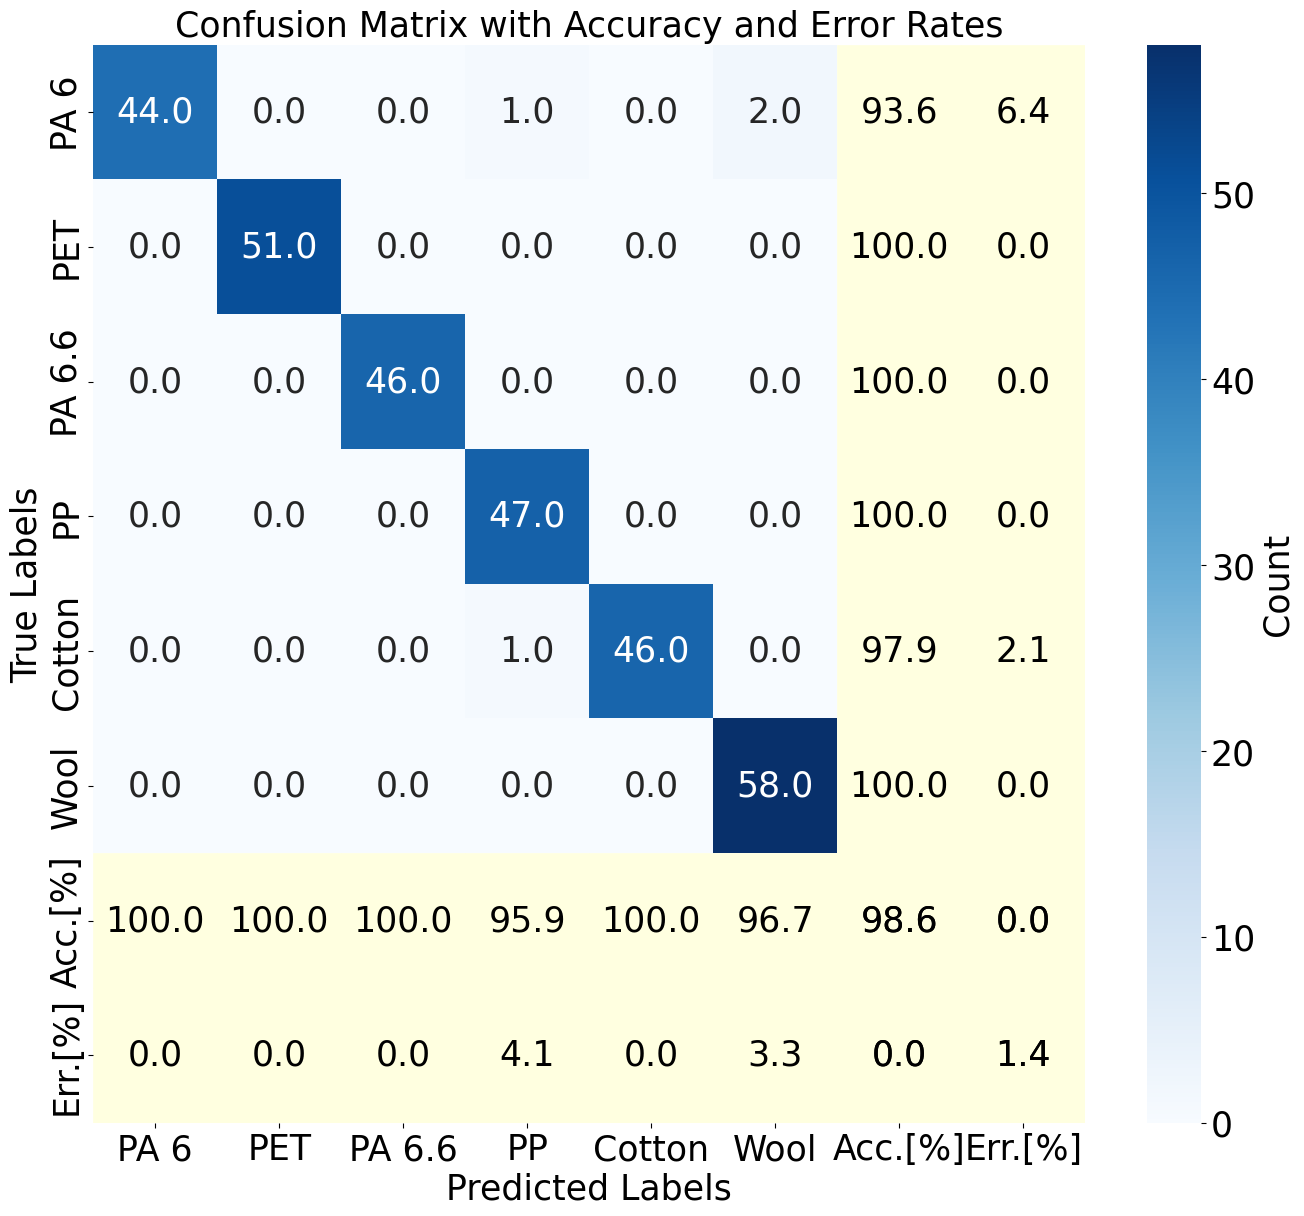

In [16]:
conf_matrixBig(best_model,xx_val,yy_val, name='data/confusion_matrix_total.pdf')

## Evaluation of all models

In [40]:
acc_val=np.zeros(28)
for i in range(28):
    best_model= load_model(f'best_model_v2_{i+1}.keras')
    acc_val[i]=best_model.evaluate(x_val_Znorm,y_val,verbose=1)[1]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - categorical_accuracy: 0.9667 - loss: 0.7021
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - categorical_accuracy: 0.9667 - loss: 0.6562
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - categorical_accuracy: 0.9667 - loss: 0.7322
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - categorical_accuracy: 0.9667 - loss: 0.7431
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - categorical_accuracy: 0.9667 - loss: 0.6784
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - categorical_accuracy: 0.9667 - loss: 0.6822
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - categorical_accuracy: 0.9667 - loss: 0.6576
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - categorical_accuracy: 0.9667 - loss: 0.7507
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - categorical_accuracy: 0.9667 - loss: 0.6961
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - categorical_accuracy: 0.9667 - loss: 0.7664
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - categorical_accuracy: 0.9667 - loss: 0.6461
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - categorical_accuracy: 0.9667 - loss:

In [42]:
acc=np.zeros(28)
for i in range(28):
    best_model= load_model(f'best_model_v2_{i+1}.keras')
    acc[i]=best_model.evaluate(xx_val,yy_val,verbose=1)[1]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - categorical_accuracy: 0.9932 - loss: 0.5090
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - categorical_accuracy: 0.9932 - loss: 0.4572
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - categorical_accuracy: 0.9865 - loss: 0.5581
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - categorical_accuracy: 0.9865 - loss: 0.5863
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - categorical_accuracy: 0.9932 - loss: 0.4779
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - categorical_accuracy: 0.9932 - loss: 0.4944
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - categorical_accuracy: 0.9932 - loss: 0.4706
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - categorical_accuracy: 0.9899 - loss: 0.5489
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - categorical_accuracy: 0.9831 - loss: 0.5353
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - categorical_accuracy: 0.9865 - loss: 0.5725
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - categorical_accuracy: 0.9865 - loss: 0.4621
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - categorical_accuracy: 0